<a href="https://colab.research.google.com/github/capofwesh20/Building-the-Eyes-of-a-Self-Driving-Car/blob/main/Project_Self_Driving_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Hardware Setup & Software Libraries

We will be utilizing GPUs to train our machine learning model, so we will need to make sure that our Colab notebook is set up correctly. Go to the menu bar and click on Runtime > Change runtime type > Hardware accelerator and **make sure it is set to GPU**. Your Colab notebook may restart once you make the change.

We're going to be using some fantastic open-source Python libraries to load our dataset (`datasets`), train our model (`transformers`), evaluate our model (`evaluate`), and build a demo of our model (`gradio`). So let's go ahead and install all of these libraries. 

In [ ]:
%%capture
!pip install datasets transformers evaluate gradio huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


# Step 1: Loading a Dataset

In this project, we will be using the `datasets` library, which can load tens of thousands of datasets with a single line of code. It can also be used to apply preprocessing functions. Learn more about the datasets library here: https://huggingface.co/docs/datasets/tutorial

Most datasets are divided into different splits. For example, you'll often see a *training* data subset, which is used to build the model, a *validation* data subset, which is used to measure the performance of the model while it is training, and a *test* dataset which is used to measure the performance of the model at the very end of training, and is usually considered to describe how well the model will perform in the real world (we'll come back to this).

Specifically, we will be using the `segments/sidewalk-semantic` dataset that is available for free from the Hugging Face Hub: https://huggingface.co/datasets/segments/sidewalk-semantic

* **Load the Semantic Sidewalk Dataset**

In [ ]:
import datasets

dataset = datasets.load_dataset('segments/sidewalk-semantic')

  0%|          | 0/1 [00:00<?, ?it/s]

* **Explore the dataset by running code below and reading the dataset card linked above. Answer the questions below**

In [ ]:
print(dataset)
dataset['train'][0]

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})


{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080 at 0x7FDA42716B10>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080 at 0x7FDA43F968D0>}

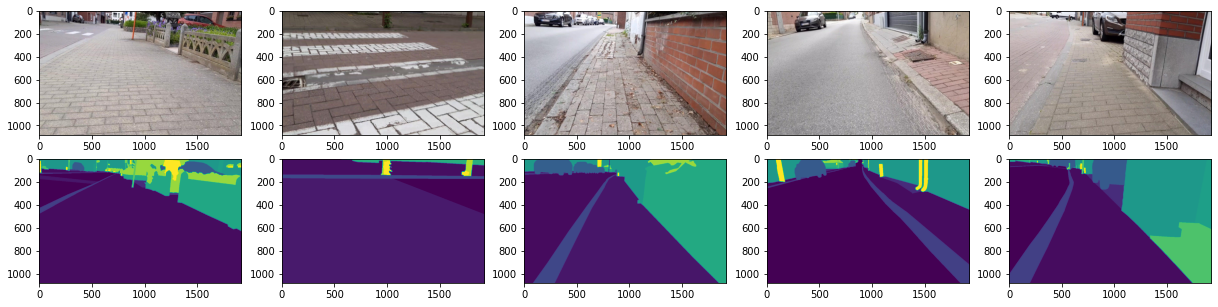

In [ ]:
#To visualize more images with equivalent label

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,5, figsize = (21,5))
for i in range(5):
  ax[0,i].imshow(dataset['train'][i]['pixel_values'], aspect = 'auto')
  ax[1,i].imshow(dataset['train'][i]['label'], aspect = 'auto')

In [ ]:
#To see how diverse the data might be
import random
from IPython.display import display, Image

for i in range(10):
  display(dataset['train'][random.randint(0,1000)]['pixel_values'])

* How many training samples do we have? 1000
* What's the size of each image? 1920 by 1080
* How many categories are in this dataset's labels? 35 
* Look at a random subset of ~10 training images, do you notice anything interesting about the images in the dataset? Are they as diverse/representative as you would expect or do they have limitations? Hugely dominated by sidewalks and the environment depicts an urban area.

* **Simplifying the Training Dataset**

You'll notice that the original dataset has many similar categories (for example, "vehicle-car" is a category, along with "vehicle-truck"). To simplify the training process, we will collapse together related categories. In the end, we will have 5 separate categories:
* 0: road/sidewalk/path
* 1: human
* 2: vehicles
* 3: other objects (e.g. traffic lights)
* 4: nature and background

For the purpose of this exercise, we will also make the images a lot smaller (64px by 64px) so that training is easier and faster. The following code processes the training images and labels.

We've written the function that applies this transformation to a given sample. Efficiently apply it to each item in the dataset, using for example 8 CPU workers (even then, this code may take a few minutes to run)

In [ ]:
import numpy as np
from PIL import Image
num_classes = 5

def transform(sample):
  #Resize label & pixel_values for faster preprocessing
    sample["pixel_values"] = sample["pixel_values"].convert("RGB").resize((64,64), Image.BICUBIC)
    #Nearest Neighbors ensures that the labels are correctly labelled
    sample["label"] = sample["label"].resize((64,64),Image.NEAREST)
    collapse_categories = {**{i: 0 for i in range(1, 8)}, 
                            **{i: 1 for i in range(8, 10)}, 
                            **{i: 2 for i in range(10, 18)}, 
                            **{i: 3 for i in range(18, 28)},
                            **{0:4}
                           }
    sample["label"] = np.vectorize(lambda x: collapse_categories.get(x, 4))(np.array(sample["label"]))
    return sample
    
dataset = dataset.map(transform, num_proc=8)

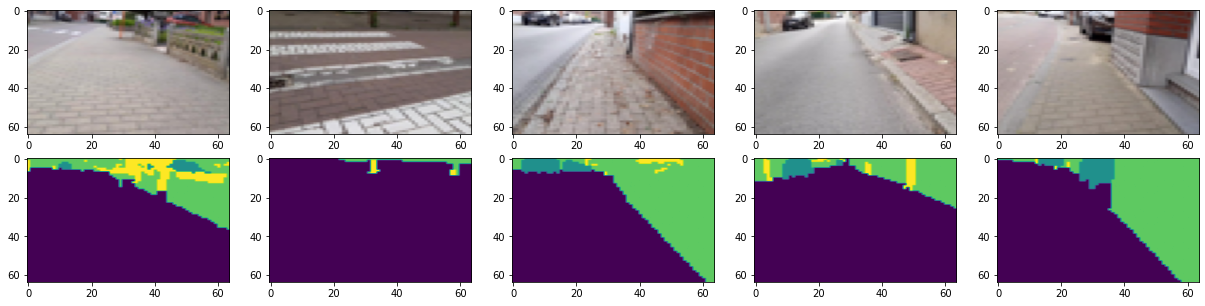

In [ ]:
#To see images as Pixel_value and Label
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,5, figsize = (21,5))
for i in range(5):
  ax[0,i].imshow(dataset['train'][i]['pixel_values'], aspect = 'auto')
  ax[1,i].imshow(dataset['train'][i]['label'], aspect = 'auto')

Finally, shuffle the dataset and split the dataset into a training dataset (with 99% of the samples) and a test dataset (with the remaining 1%). We have a very small test dataset so that the evaluation step is quick. If you were training a model in a more realistic setting, you would pick a bigger evaluation dataset.

You might find the `train_test_split()` method in the `datasets` library useful.

In [ ]:
#Randomnize the dataset and set a seed valu
dataset = dataset.shuffle(seed = 42)


dataset = dataset["train"].train_test_split(test_size=0.01)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [ ]:
test_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 10
})

In [ ]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 990
})

After you run the steps above, examine the `train_ds` and `test_ds` objects, and confirm that the samples look as you expect. Specifically,

* How many training and test samples do we have? 990,10
* What's the size of each image? 64 * 64
* What are the potential risks or downsides of having such a small test datset? The dataset consist more of sidewalk and less representative

# Step 2: Loading a Pretrained Model

We will be using the `transformers` library, which can load tens of thousands of machine learning models with a few lines of code. It can also be used to fine-tune these models. Learn more about the `transformers` library here: https://huggingface.co/docs/transformers/index

Specifically, we will be using the `Segformer` model that is available for anyone from the Hugging Face Hub: https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512. While the details of this architecture are beyond the scope of this course, we will point out that it is based on transformers, just like the vision transformers (ViT) network we used last week for image classification. Also, notice that it has already been fine-tuned for detecting everyday objects. We will _further_ fine-tune it for our specific dataset to speed up the training process.

* **Load the Segformer Model and FeatureExtractor for Inference**

In [ ]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')

model.eval()
model.to(device);

We also need to load the **feature extractor** corresponding to the model, so that we can convert the input images into a feature vector that the model can take as input.

In [ ]:
extractor = AutoFeatureExtractor.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')

# Step 3: Fine-tuning Your Model on the Dataset

## 3a. Preprocess the Dataset and Load the Metric

Off the shelf, the Segformer model will not be usable for the task that we have in mind, since it was trained for "general" image segmentation, not for the specific categories that we would like to predict. As a result, we will need to "fine-tune" our model.

Learn more about fine-tuning models with the `transformers` library here: https://huggingface.co/docs/transformers/training

We will also need to decide which metric to use for our task. Since our task is image segmentation, the `mean IOU` metric seems reasonable: https://huggingface.co/spaces/evaluate-metric/mean_iou

* **Preprocess the Dataset**

We will convert the images to feature vectors on the fly as we train the model using the `set_transform()` method. This time, the `transform()` has been left for you to write:

In [ ]:
from torchvision.transforms import Compose, ColorJitter, ToTensor

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def transform(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = extractor(images, labels)
    return inputs

train_ds.set_transform(transform)
test_ds.set_transform(transform)

## 3b. Fine-Tune the Segformer Model on a Training Subset (and Overfit)

As we discussed in lecture, a good way to start training a model is by making sure that you are able to overfit on a small subset of the training dataset. Train your model on 10 images from your training dataset for 10 epochs. 

We will start by defining our training hyperparameters as a `TrainingArguments` instance.

Note that we leave the choice of learning rate to you. You may need to try different learning rates and batch sizes until you are able to overfit successfully on this training dataset.


In [ ]:
train_subset_ds = train_ds.select(range(10))
train_subset_ds.set_transform(transform)

In [ ]:
train_subset_ds.set_transform(transform)

In [ ]:
overfit_output_dir = "/content/overfit-segmentation-model"
model_overfit_dir = f"{overfit_output_dir}"
print(model_overfit_dir)

/content/overfit-segmentation-model


In [ ]:
from transformers import TrainingArguments
from transformers import Trainer


lr = 6e-4
epochs = 10
batch_size = 2

training_args = TrainingArguments(
    model_overfit_dir,
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="steps",
    save_steps=20,
    eval_steps=5,
    logging_strategy="epoch",
    logging_steps=1,
)


trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_subset_ds,
  eval_dataset=test_ds,
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 50
/usr/local/lib/python3.7/dist-packages/transformers/data/data_collator.py:131: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch[k] = torch.tensor([f[k] for f in features])


Step,Training Loss,Validation Loss
5,No log,4.449140
10,4.957300,2.530019
15,2.730200,2.307283
20,2.625300,1.229673
25,1.426400,1.623909
30,1.281600,1.756136
35,1.302100,1.357320
40,0.621500,1.080673
45,0.773000,1.150608
50,1.041500,1.234036


***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Saving model checkpoint to /content/overfit-segmentation-model/checkpoint-20
Configuration saved in /content/overfit-segmentation-model/checkpoint-20/config.json
Model weights saved in /content/overfit-segmentation-model/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Saving model checkpoint to /content/overfit-segmentation-model/checkpoint-40
Configuration saved in /content/overfit-segmentation-model/checkpoint-40/config.json
Model weights saved in /content/overfit-s

TrainOutput(global_step=50, training_loss=1.728727478981018, metrics={'train_runtime': 35.0953, 'train_samples_per_second': 2.849, 'train_steps_per_second': 1.425, 'total_flos': 1770743188684800.0, 'train_loss': 1.728727478981018, 'epoch': 10.0})

* **Plot the Loss on the Training and Test Sets Over the 10 Epochs** 

In [ ]:
import pandas as pd

# Eval and training loss are logged in separate entries.
# Or take a look at the connected Wandb
df = pd.DataFrame(trainer.state.log_history)[["eval_loss", "loss", "epoch"]]

df_eval_loss = df[["eval_loss", "epoch"]].dropna()
df_train_loss = df[["loss", "epoch"]].dropna()

df_epoch = df_eval_loss.merge(df_train_loss, on="epoch", how="left")

plt = df_epoch.plot.line(x="epoch", y=["loss","eval_loss"])

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 10
  Batch size = 2


{'eval_loss': 1.182166337966919,
 'eval_runtime': 2.4814,
 'eval_samples_per_second': 4.03,
 'eval_steps_per_second': 2.015,
 'epoch': 10.0}

* Is there any sign of overfitting? No, Validation loss is less than training loss probable

## 3c. Fine-Tune the Segformer Model on the Entire Training Set

* **Load the Mean IoU Metric**

In addition to the loss, we now have to decide on a *metric* we will use to measure the performance for our machine learning model. A natural choice for image classification is *mean Intersection-over-Union (mean IoU)*, which measures the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth. It is probably the most common metric used for segmentation tasks. 

Read about the `evaluate` library, which contains many common machine learning metrics here: https://github.com/huggingface/evaluate

And use `evaluate.load()` to load the mean IoU metric:

In [ ]:
regfit_output_dir = "/content/regular-segmentation-model"
model_regfit_dir = f"{regfit_output_dir}"
print(model_regfit_dir) 

/content/regular-segmentation-model


In [ ]:
import numpy as np
import evaluate
from torch import nn

metric = evaluate.load('mean_iou')

We will need to write some code to apply the mean IOU metric to the right layers of the neural network. We first need to convert our predictions to logits first, and then reshaped to match the size of the labels. This code has already been written for you:

In [ ]:
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        #Resize image to 512
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1) #Pick the highest probabiity category per pixel

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_classes,
            ignore_index=255, #ignore outlier
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics


Now, we will take all of the code that you have written and use it to fine-tune the Segformer model on the sidewalk segmentation dataset. Simply run the code below, and your model will fine-tune for 5 epochs. On a **GPU**, this should take about or leass than 30 minutes with the default settings.

**Important Note:** these default settings may **NOT** produce a very good segmentation model. For this task, you likely need significantly more training time. That is OK, the point of this exercise is not to train a highly-performant model, but to walk through the steps that would be needed to do that. We will **NOT** be looking at the performance of this model to grade your project. If you have been able to overfit on a small training subset (in part 3b), and the loss is going down in this part, that is sufficient.

In [ ]:
lr = 0.00005
epochs = 5
batch_size = 1

training_args = TrainingArguments(
    "regular-segmentation-model",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="steps",
    save_steps=200,
    eval_steps=200,
    logging_steps=20,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

## 3d. Upload your model to the Hugging Face Hub!

In two lines of code, upload your feature extractor and model to the Hugging Face Hub!

In [ ]:
extractor.push_to_hub("my-segmentation-model",use_auth_token=True)

Feature extractor saved in /tmp/tmpv994o59a/preprocessor_config.json
Uploading the following files to capofwesh20/my-segmentation-model: preprocessor_config.json


CommitInfo(commit_url='https://huggingface.co/capofwesh20/my-segmentation-model/commit/e420cdf8f738c23d973919cc11a40cf387a7e859', commit_message='Upload feature extractor', commit_description='', oid='e420cdf8f738c23d973919cc11a40cf387a7e859', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.push_to_hub("my-segmentation-model",use_auth_token=True)

Configuration saved in /tmp/tmpefz3a0_d/config.json
Model weights saved in /tmp/tmpefz3a0_d/pytorch_model.bin
Uploading the following files to capofwesh20/my-segmentation-model: config.json,pytorch_model.bin


CommitInfo(commit_url='https://huggingface.co/capofwesh20/my-segmentation-model/commit/a23bf2ba70f573496bc0e0f28190066819fce9be', commit_message='Upload SegformerForSemanticSegmentation', commit_description='', oid='a23bf2ba70f573496bc0e0f28190066819fce9be', pr_url=None, pr_revision=None, pr_num=None)

# Step 4: Reporting Model Metrics

* **Plot the Loss and Mean IoU on the Training and Test Sets Over the 5 Epochs** 

In [ ]:
import pandas as pd

# Eval and training loss are logged in separate entries.
df = pd.DataFrame(trainer.state.log_history)[["loss", "epoch", "eval_loss", "eval_mean_iou"]]

df_eval_loss = df[["eval_loss", "eval_mean_iou", "epoch"]].dropna()
df_train_loss = df[["loss", "epoch"]].dropna()

df_epoch = df_eval_loss.merge(df_train_loss, on="epoch", how="left")
plt = df_epoch.plot.line(x="epoch", y=["loss","eval_loss", "eval_mean_iou"])

# Step 5: Building a Demo

A high-level metric like mean test IoU doesn't give us a great idea on how the model will work when presented with new data from the real world. To understand this, we will build a web-based demo that we can use on our phones or computers through a web browser to test our model.

The `gradio` library lets you build web demos of machine learning models with just a few lines code. Learn more about Gradio here: https://gradio.app/getting_started/

Gradio lets you build machine learning demos simply by specifying (1) a prediction function, (2) the input type and (3) the output type of your model. We have already written the prediction function here:

In [ ]:
import matplotlib.pyplot as plt

def classify(im):
  inputs = extractor(images=im, return_tensors="pt").to("cuda")
  outputs = model(**inputs)
  logits = outputs.logits
  classes = logits[0].detach().cpu().numpy().argmax(axis=0)
  colors = np.array([[128,0,0], [128,128,0], [0, 0, 128], 	[128,0,128], [0, 0, 0]])
  return colors[classes]

* **Build a Gradio web demo of your image classifier and `launch()` it**

Create a `gradio.Interface` and launch it! For image classification, the input component should be an `Image` component that passes the image in as a "PIL" image, and the output should be a `Image` component as well

In [ ]:
import gradio as gr

interface = gr.Interface(
    fn = classify,
    inputs = 'image',
    outputs = 'image'
)

interface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://22501.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fd844cadc50>,
 'http://127.0.0.1:7861/',
 'https://22501.gradio.app')

# Step 6: Trying your Model with "Real World" Data!

* **Use the share link created above to open up your app on your phone**

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1NZ-aIfFYdPTpYhmlSX4MFscWGU5HmTcu/preview" width="640" height="480" allow="autoplay"></iframe>

Now test your model on some real images -- perhaps you can go outside and take a picture of your car. Or you can upload a picture of a road you found online. Although your model may not have been trained for very long, is it still able to distinguish any object classes? Why do you think that may or may not be the case?  



# **Try a zero-shot image segmentation model. **

If you're tired of waiting for your model to train, you could try a zero-shot image segmentation models, which does not have to be retrained for specific applications. How well does a zero-shot segmentation model like GroupViT work for this problem? 



With only text supervision and without any pixel- level annotations, GroupViT learns to group together se- mantic regions and successfully transfers to the task of se- mantic segmentation in a zero-shot manne

In [ ]:
#importing model
from transformers import AutoProcessor, GroupViTModel
import torch

# load model + processor
model_name = "nvidia/groupvit-gcc-yfcc"
processor = AutoProcessor.from_pretrained(model_name)
model = GroupViTModel.from_pretrained(model_name)

# move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

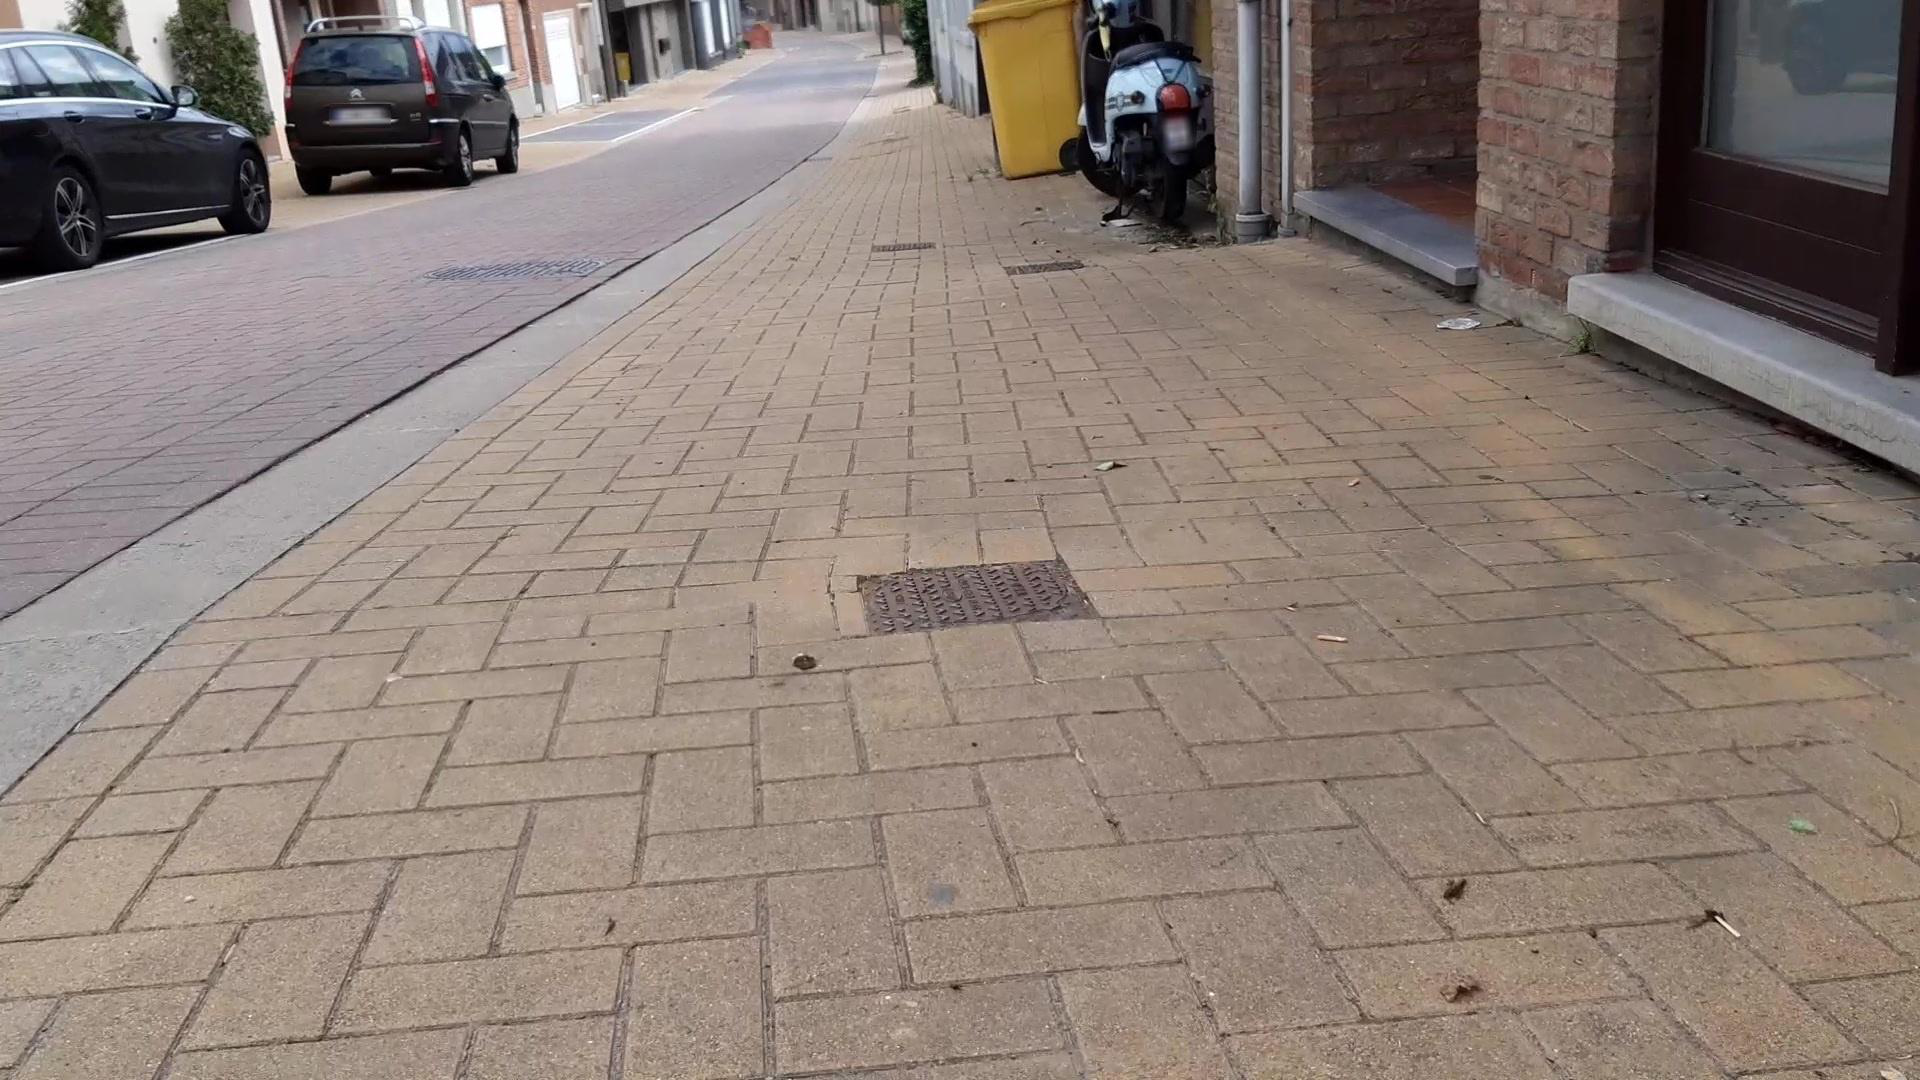

In [ ]:
test_ds[0]

from datasets import load_dataset
from PIL import Image

# load image + ground truth map
ds = load_dataset("segments/sidewalk-semantic", split="train")
image = ds[5]['pixel_values']
display(image)
segmentation_map = ds[0]['label']
image = image.resize((224, 224))

In [ ]:
path = ['road/sidewalk/path', 'human', 'vehicles', 'other objects (e.g. traffic lights)', 'nature and background']

In [ ]:
inputs = processor(
    text=[f"a photo of a {word}" for word in path],
    images=image,
    return_tensors="pt",
    padding=True,
).to(device)

In [ ]:
for k,v in inputs.items():
  print(k,v.shape)

outputs = model(**inputs, output_segmentation=True)
logits = outputs.segmentation_logits

logits

input_ids torch.Size([5, 16])
attention_mask torch.Size([5, 16])
pixel_values torch.Size([1, 3, 224, 224])


tensor([[[[933.6376, 933.6376, 933.6376,  ..., 939.1216, 939.1216, 939.1216],
          [933.6376, 933.6376, 933.6376,  ..., 939.1216, 939.1216, 939.1216],
          [933.6376, 933.6376, 933.6376,  ..., 939.1216, 939.1216, 939.1216],
          ...,
          [945.8557, 945.8557, 945.8557,  ..., 930.1638, 930.1638, 930.1638],
          [945.8557, 945.8557, 945.8557,  ..., 930.1638, 930.1638, 930.1638],
          [945.8557, 945.8557, 945.8557,  ..., 930.1638, 930.1638, 930.1638]],

         [[607.5972, 607.5972, 607.5972,  ..., 649.1027, 649.1027, 649.1027],
          [607.5972, 607.5972, 607.5972,  ..., 649.1027, 649.1027, 649.1027],
          [607.5972, 607.5972, 607.5972,  ..., 649.1027, 649.1027, 649.1027],
          ...,
          [725.8108, 725.8108, 725.8108,  ..., 681.0901, 681.0901, 681.0901],
          [725.8108, 725.8108, 725.8108,  ..., 681.0901, 681.0901, 681.0901],
          [725.8108, 725.8108, 725.8108,  ..., 681.0901, 681.0901, 681.0901]],

         [[672.9641, 672.9641,

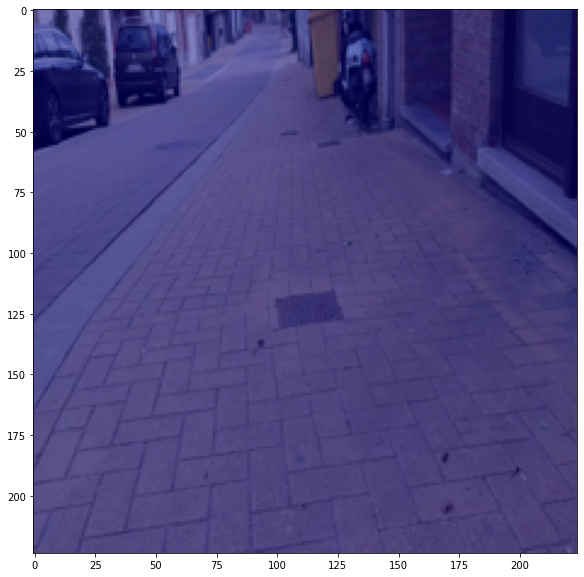

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
logits = nn.functional.interpolate(logits.detach().cpu(),
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array([[128,0,0], [128,128,0], [0, 0, 128], 	[128,0,128], [0, 0, 0]])
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

The GroupVit did an amazing job!!!